## Test of the rotation augmentation on dogs-cats

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

We import the old fastai library for its training loop.

In [9]:
from nb_001b import *
from PIL import Image
import PIL, matplotlib.pyplot as plt
import torch
import os, random
from torch.utils.data import Dataset

In [22]:
PATH = Path("data/dogscats/")
os.makedirs(PATH,exist_ok=True)

In [11]:
bs=64
sz=224

# Torchvision data aug

All the relevant functions to get dataloaders.

In [20]:
import torchvision

In [12]:
default_device = torch.device('cuda', 0)

In [13]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    classes.sort(key=lambda d: d.name)
    return classes

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

In [62]:
from PIL import Image
class TransformedFilesDataset(Dataset):#Renamed to avoid conflict with fastai FilesDataset
    def __init__(self, folder, tfms):
        self.tfms = torchvision.transforms.Compose(tfms)
        cls_dirs = find_classes(folder)
        self.fns, self.y = [], []
        self.classes = [cls.name for cls in cls_dirs]
        for i, cls_dir in enumerate(cls_dirs):
            fnames = get_image_files(cls_dir)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i])
        x = self.tfms(x)
        return np.array(x, dtype=np.float32).transpose(2,0,1)/255,self.y[i]

In [92]:
class DeviceDataLoader():
    def __init__(self, dl, device, stats):
        self.dl,self.device = dl,device
        self.m, self.s = map(lambda x:torch.tensor(x, dtype=torch.float32, device=device), stats)
        
    def __iter__(self):
        for b in self.dl:
            x, y = b[0].to(self.device),b[1].to(self.device)
            x = (x - self.m[None,:,None,None]) / self.s[None,:,None,None]
            yield x,y
    
    def __len__(self): return (len(self.dl))

Let's get the DataLoader from pytorch since fastai replaced the definition.

In [64]:
from torch.utils.data.dataloader import DataLoader as DataLoader1
def get_dataloader(ds, bs, shuffle, device, stats):
    return DeviceDataLoader(DataLoader1(ds, batch_size=bs, shuffle=shuffle,num_workers=0), device, stats)

In [65]:
class DataBunch():
    def __init__(self, trn_ds, val_ds, stats, bs=64, device=None):
        self.device = default_device if device is None else device
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.trn_dl = get_dataloader(trn_ds, bs,   shuffle=True,  device=self.device, stats=stats)
        self.val_dl = get_dataloader(val_ds, bs*2, shuffle=False, device=self.device, stats=stats)

    @classmethod
    def from_files(cls, Path, size, trn_tfms, val_tfms, stats, trn_name='train', val_name='valid', bs=64, device=None):
        trn_ds, val_ds = TransformedFilesDataset(Path/trn_name, trn_tfms), TransformedFilesDataset(Path/val_name, val_tfms)
        return cls(trn_ds, val_ds, stats, bs, device)

In [66]:
size = 224

In [144]:
stats = [np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])]
trn_tfms = [torchvision.transforms.Pad(8, padding_mode='symmetric'),
            torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
            torchvision.transforms.RandomResizedCrop(size)]
val_tfms = [torchvision.transforms.Resize(size), 
            torchvision.transforms.CenterCrop(size)]
data = DataBunch.from_files(PATH, (size,size), trn_tfms, val_tfms, stats, bs=bs)

In [145]:
x,y = next(iter(data.trn_dl))

In [146]:
x.size()

torch.Size([64, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


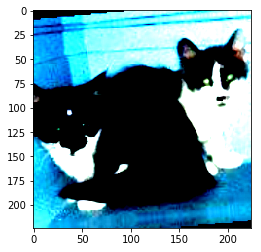

In [147]:
plt.imshow(x[0].cpu().numpy().transpose(1,2,0))

In [148]:
%time for (x,y) in iter(data.trn_dl): pass

Wall time: 3min 37s


## Our way

In [71]:
def affine_transform(img, matrix, interpol=True, padding='reflect'):
    """
    Applies an affine transformation to an image.
    
    Optional: only computes the new coordinates without doing the interpolation to create the new images.
    Args:
    x: a batch of images
    matrix: a matrix of size 2 by 3 describing the transformation.
            if the transformation is Ax + b, the matrix is (A|b)
    interpol: if False, returns only the new coordinates
    padding: padding to apply during the interpolation. Supports zeros, border, reflect
    
    """
    coords = F.affine_grid(matrix[None], img[None].size())
    return interpolate(img[None],coords,padding) if interpol else coords

In [72]:
def interpolate(x, coords, padding='reflect'):
    if padding=='reflect':#Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding='zeros'
    return F.grid_sample(x, coords, padding_mode=padding)

In [73]:
img = Image.open(data.trn_dl.dl.dataset.fns[0])
img = torch.tensor((np.array(img, dtype=np.float32)/255).transpose(2,0,1))

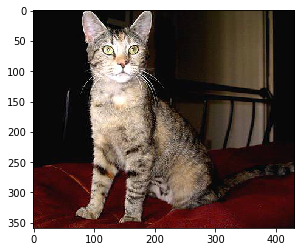

In [74]:
plt.imshow(img.numpy().transpose(1,2,0))

In [75]:
theta = 10 * math.pi / 180
matrix = torch.tensor([[math.cos(theta), -math.sin(theta), 0],
                       [math.sin(theta), math.cos(theta), 0]])

In [76]:
res = affine_transform(img, matrix)

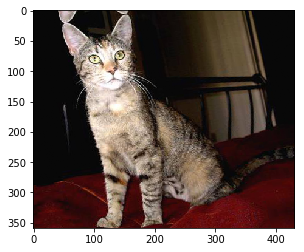

In [77]:
plt.imshow(res[0].numpy().transpose(1,2,0))

In [78]:
matrix = torch.tensor([[0.8, 0, 0],
                       [0, 0.8, 0]])

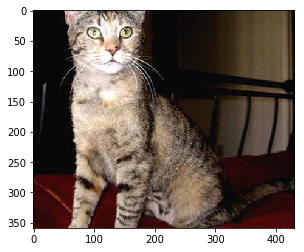

In [79]:
res = affine_transform(img, matrix)
plt.imshow(res[0].numpy().transpose(1,2,0))

In [80]:
def crop(coords, start, size):
    t,l = start
    d,r = t + size[0], l + size[1] 
    return coords[:,t:d,l:r,:]

In [81]:
coords = affine_transform(img,matrix,False)
coords = crop(coords,(50,10),(200,120))
res = interpolate(img[None], coords)

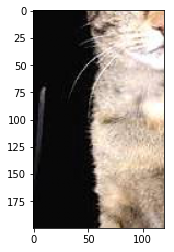

In [82]:
plt.imshow(res[0].numpy().transpose(1,2,0))

In [166]:
_, h, w = img.size()

In [175]:
ratio = min(h,w) / 224
img_size = torch.Size([1,3,int(h/ratio),int(w/ratio)])
matrix = torch.eye(3)[:2,:]
coords = F.affine_grid(matrix[None], img_size)
res = interpolate(img[None], coords)

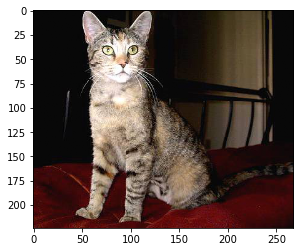

In [177]:
plt.imshow(res[0].numpy().transpose(1,2,0))

In [178]:
res.size()

torch.Size([1, 3, 224, 268])

In [169]:
img_size

torch.Size([1, 3, 224, 268])

In [83]:
def get_random_rot_matrix(degrees):
    theta = random.uniform(-degrees,degrees) * math.pi / 180
    return torch.tensor([[math.cos(theta), -math.sin(theta), 0],
                         [math.sin(theta), math.cos(theta),  0],
                         [0,               0,                1]])

In [84]:
def get_random_scale_matrix(zoom_range):
    scale = random.uniform(*zoom_range)
    return torch.tensor([[scale, 0, 0],
                         [0, scale, 0],
                         [0,  0,    1]])

In [163]:
class CustomTfm():
    
    def __init__(self, degrees, min_zoom, max_zoom, size):
        self.degrees,self.range_zooms,self.size = degrees,(min_zoom,max_zoom),size
        
    def __call__(self, x):
        matrix = get_random_rot_matrix(self.degrees)
        matrix = matrix.mm(get_random_scale_matrix(self.range_zooms))
        matrix = matrix[:2,:]
        _, h, w = x.size()
        ratio = min(h,w) / self.size
        img_size = torch.Size([1,3,int(h/ratio),int(w/ratio)])
        coords = F.affine_grid(matrix[None], img_size)
        a = random.randint(0, img_size[2]-self.size) if img_size[2] >= self.size else 0
        b = random.randint(0, img_size[3]-self.size) if img_size[3] >= self.size else 0
        coords = crop(coords, (a,b), (self.size,self.size))
        #if coords.size(1) < self.size or coords.size(2) < self.size: pdb.set_trace()
        return interpolate(x[None], coords)

In [164]:
tfm = CustomTfm(10, 0.8, 1, 224)

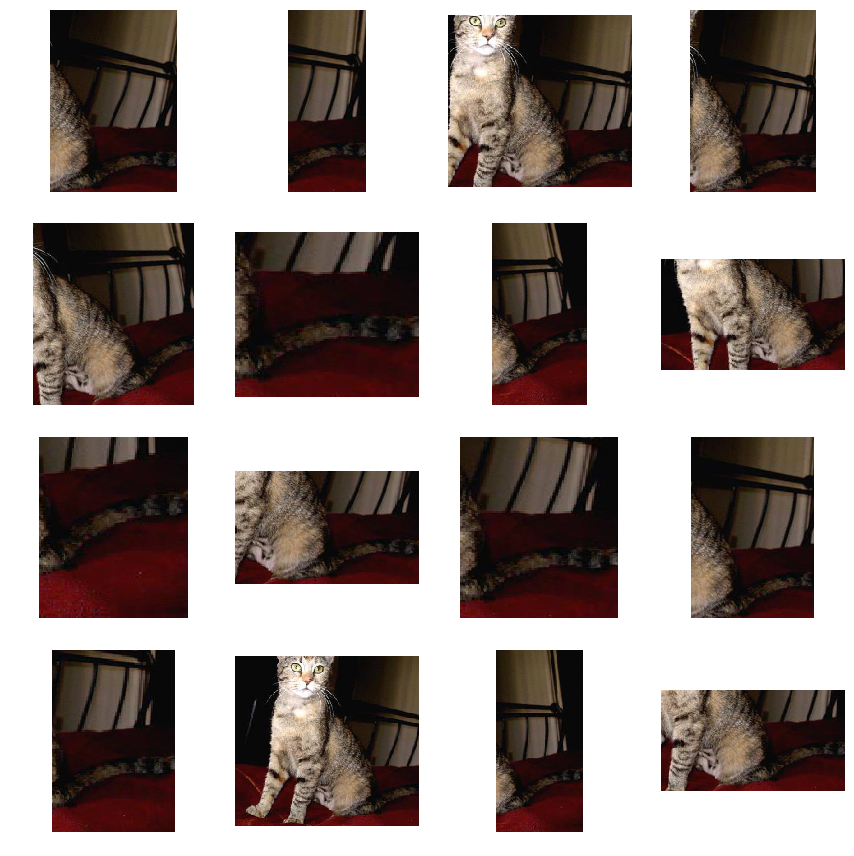

In [165]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
for ax in axs.flatten():
    res = tfm(img)
    ax.imshow(res[0].numpy().transpose(1,2,0))
    ax.axis('off')
    plt.tight_layout()

Load a ModelData object and a Learner from the old fastai library to use the training loop.

Let's try the same thing but do the rotaiton on the CPU instead.

In [157]:
from PIL import Image
class TransformedFilesDataset1(Dataset):
    def __init__(self, folder, tfms):
        self.tfms = tfms
        cls_dirs = find_classes(folder)
        self.fns, self.y = [], []
        self.classes = [cls.name for cls in cls_dirs]
        for i, cls_dir in enumerate(cls_dirs):
            fnames = get_image_files(cls_dir)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i])
        w,h = x.size
        x = torch.tensor(np.array(x, dtype=np.float32).transpose(2,0,1)/255)
        x = self.tfms(x)[0]
        return x,self.y[i]

In [154]:
class DataBunch1():
    def __init__(self, trn_ds, val_ds, stats, bs=64, device=None):
        self.device = default_device if device is None else device
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.trn_dl = get_dataloader(trn_ds, bs,   shuffle=True,  device=self.device, stats=stats)
        self.val_dl = get_dataloader(val_ds, bs*2, shuffle=False, device=self.device, stats=stats)

    @classmethod
    def from_files(cls, Path, size, trn_tfms, val_tfms, stats, trn_name='train', val_name='valid', bs=64, device=None):
        trn_ds, val_ds = TransformedFilesDataset1(Path/trn_name, trn_tfms), TransformedFilesDataset1(Path/val_name, val_tfms)
        return cls(trn_ds, val_ds, stats, bs, device)

In [155]:
stats = [np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])]
size = 224
trn_tfms = CustomTfm(10, 0.8, 1, 224)
val_tfms = CustomTfm(0, 1, 1, 224)
data = DataBunch1.from_files(PATH, (size,size), trn_tfms, val_tfms, stats, bs=bs)

In [156]:
%time for (x,y) in iter(data.trn_dl): pass

Wall time: 3min 44s
